In [187]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
import utils
import pandas as pd
import utils
import importlib
utils = importlib.reload(utils)
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import acrh_from_norm_meanpose_nowarmup as arch
arch = importlib.reload(arch)
import vqvae_run
vqvae_run = importlib.reload(vqvae_run)

/Users/annkle/Documents/KTH/Github/DWPose/conda_torch_env/bin/python


In [188]:
# torch.cuda.is_available()
device = "mps" if torch.backends.mps.is_available() else "cpu"
torch.set_default_device(device)

print(f"Using device: {device}")

Using device: mps


In [189]:
batch_size = 60
img_size = (32, 32)  # (width, height) # NOT USED
input_dim = 112
hidden_dim = 512
latent_dim = 16
n_embeddings= 512
output_dim = 112
commitment_beta = 0.30
lr = 0.002
epochs = 50
print_step = 50
sequence_length = 30
down_t = 3

In [190]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pickle
import importlib
import utils
utils = importlib.reload(utils)
import pandas as pd


def load_lexicon_data(sslc_pose, path_to_data, output_dim=112, normalize_by_mean_pose=True, num_workers=0, batch_size=256, sequence_length=30, jsons_path='lexicon_jsons/out', pin_memory=False, shuffle
=True, train=False):
    """
    sslc_pose: pandas dataframe; df_train_sign, df_val_sign, df_test_sign
    # Loading only corpus data (from zip file)
    load up to torch.utils.data.DataLoader
    """
    # for corpus: sslc_pose = pd.read_csv('./SSL_video_eaf/sslc_pose_2.csv', encoding='utf-8')  # sslc_pose_2.csv
    len_data = len(sslc_pose)

    if path_to_data.endswith(".zip"):
        print("Loading data from zip file")
        dataset = utils.ZipPoseDataset(
            path_to_data, in_memory=True,
            dtype=torch.float32,
            max_length=sequence_length,
            df=sslc_pose,
            normalize_by_mean_pose=normalize_by_mean_pose
        )
        #threshold_10 = round(len_data * 0.1)
        #training_dataset = dataset.slice(threshold_10, None)  
        #test_dataset = dataset.slice(0, threshold_10)
        # Shuffle is only slow without in_memory since the zip file is read sequentially
        # Reading from multiple workers errors out since the zip file is read sequentially
        #if train:
        #    dataset = utils.PackedDataset(dataset, max_length=sequence_length, shuffle=shuffle)
        loader = DataLoader(
            dataset, batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=pin_memory,
            shuffle=True,
            generator=torch.Generator(device='mps')
        )
        #test_loader = DataLoader(
        #    test_dataset, batch_size=batch_size,
        #    shuffle=False, num_workers=num_workers
        #)
    else:
        train_df, test_df = train_test_split(sslc_pose, test_size=0.2, random_state=42)
        training_dataset = utils.PoseDataset2(
            df=train_df, root_dir=jsons_path,   # ./SSL_video_eaf/SSLC_poses/
            sequence_length=sequence_length, normalize_by_mean_pose=normalize_by_mean_pose
        )
        test_dataset = utils.PoseDataset2(
            df=test_df, root_dir=jsons_path,   # ./SSL_video_eaf/SSLC_poses/
            sequence_length=sequence_length, normalize_by_mean_pose=normalize_by_mean_pose
        )
        kwargs = {'num_workers': num_workers, 'pin_memory': True} 
        train_loader = DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=False, **kwargs)
        test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False,  **kwargs)
    return dataset, loader


In [191]:
# Loading DF
with open('./lexicon_jsons/sign_data_frames_info_train.pkl', 'rb') as file:  # '../../fmalmb/data/signs_and_phrases/sign_data_frames_info_train.pkl'
    df_train_sign = pickle.load(file) 
with open('./lexicon_jsons/sign_data_frames_info_val.pkl', 'rb') as file:  # '../../fmalmb/data/signs_and_phrases/sign_data_frames_info_val.pkl'
    df_val_sign = pickle.load(file) 
with open('./lexicon_jsons//sign_data_frames_info_test.pkl', 'rb') as file:  # '../../fmalmb/data/signs_and_phrases/sign_data_frames_info_test.pkl'
    df_test_sign = pickle.load(file) 

In [218]:
kwargs = {'num_workers': 0, 'pin_memory': False, 'shuffle': True} 

sequence_length = 30

# corpus jsons path jsons_path='./SSL_video_eaf/SSLC_poses/'
# lexicon zip path: lexicon_jsons/lexicon_poses_norm_train.zip

training_dataset, train_loader = load_lexicon_data(
    df_train_sign, 'lexicon_jsons/lexicon_poses_norm_train2.zip',
    normalize_by_mean_pose=True,
    batch_size=60,
    train=False,
    **kwargs
)
i = 0
for batch in train_loader:
    print(batch.shape)
    i += 1
    if i == 4:
        break

Loading data from zip file
ZipPoseDataset @ lexicon_jsons/lexicon_poses_norm_train2.zip with max_length=30, in_memory=True
Total files 17129
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800

In [247]:
# Initialize model
from MotionGPT.mGPT.archs import mgpt_vq

import importlib

# Reload the module
importlib.reload(mgpt_vq)

# Re-import the class
from MotionGPT.mGPT.archs.mgpt_vq import VQVae, Decoder, Encoder


batch_size = 60
img_size = (32, 32)  # (width, height) # NOT USED
input_dim = 112
hidden_dim = 512
latent_dim = 32  # 16
n_embeddings = 1024  # 512
output_dim = 112
commitment_beta = 0.30
lr = 2e-4
epochs = 100
print_step = 50
sequence_length = 30
down_t = 1

model = VQVae(down_t=down_t, nfeats=input_dim, code_num=n_embeddings, code_dim=latent_dim, output_emb_width=512).to(device)
#quantizer = VQEmbeddingEMA(n_embeddings=512, embedding_dim=512).to(device)
#quantizer = arch.QuantizeEMAResetCounter(nb_code=n_embeddings, code_dim=latent_dim, mu=0.99).to(device)
quantizer = arch.VQEmbeddingEMA(n_embeddings=n_embeddings, embedding_dim=latent_dim).to(device)
model.quantizer = quantizer

hyperparameters = {"arch": "MGPTmse", "misc": "norm_oldquant_1024_32"}
log_dir = "runs/" + "_".join([f"{key}={value}" for key, value in hyperparameters.items()])
writer = SummaryWriter(log_dir)
model_name = 'vqvae_' + '_'.join([f"{key}_{value}" for key, value in hyperparameters.items()])+'.pth'
print(model_name)

vqvae_arch_MGPTmse_misc_norm_oldquant_1024_32.pth


In [220]:
# validation loader
val_dataset, val_loader = load_lexicon_data(
    df_val_sign, 'lexicon_jsons/lexicon_poses_norm_val2.zip',
    normalize_by_mean_pose=True, num_workers=0,
    batch_size=60
)
i = 0
for batch in val_loader:
    print(batch.shape)
    i += 1
    if i == 4:
        break

Loading data from zip file
ZipPoseDataset @ lexicon_jsons/lexicon_poses_norm_val2.zip with max_length=30, in_memory=True
Total files 2141
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
torch.Size([60, 112, 30])
torch.Size([60, 112, 30])
torch.Size([60, 112, 30])
torch.Size([60, 112, 30])


In [248]:
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import LambdaLR

mse_loss = nn.MSELoss()

def euclidean_loss(output, target):
    # print("output.shape, target.shape ", output.shape, target.shape)
    x = output.transpose(2,1)
    y = target.transpose(2,1)
    return torch.mean(torch.sqrt(torch.sum((x - y) ** 2, dim=-1)))

#optimizer = Adam(model.parameters(), lr=lr)
optimizer = AdamW(model.parameters(), lr=lr)

def lr_lambda(epoch):
    # Warm-up period (10 epochs) followed by cosine annealing (40 epochs)
    if epoch < 10:
        # Linearly increase the learning rate during warm-up
        return epoch / 10
    else:
        # Cosine decay
        return 0.5 * (1 + torch.cos(torch.tensor((epoch - 10) / (50 - 10) * torch.pi)))
    
def lr_lambda_nowarmup(epoch):
    # Cosine annealing
    return 0.5 * (1 + torch.cos(torch.tensor((epoch) / (50) * torch.pi)))

scheduler = LambdaLR(optimizer, lr_lambda_nowarmup)

In [249]:
print("Start training VQ-VAE...")

model.to(device)
model.train()

commitment_beta = 0.1

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, x in enumerate(train_loader):
        x = x.transpose(2,1)
        x = x.to(device)

        optimizer.zero_grad()

        #x_hat, commitment_loss, codebook_loss, perplexity = model(x)
        x_hat, commit_and_codebook_loss, perplexity = model(x)
        # print("x_hat.size() ", x_hat.size())
        # print("x.size() ", x.size())
        recon_loss = 100 * euclidean_loss(x_hat, x)
        #recon_loss = mse_loss(x_hat, x)
        loss = recon_loss + commit_and_codebook_loss * commitment_beta
        overall_loss += recon_loss.item()    
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()
        
        if batch_idx % print_step ==0: 
            print("epoch:", epoch + 1, "( batch: ", batch_idx + 1, "/", len(train_loader),") recon_loss:", recon_loss.item(), " perplexity: ", perplexity.item(), 
              " codebook loss: ", commit_and_codebook_loss.item(), "\n total_loss: ", loss.item(), "\n")
    
    scheduler.step()

    # Validation Loop
    model.eval()  # switch to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for batch_idx, x_val in enumerate(val_loader):
            x_val = x_val.transpose(2,1)
            x_val = x_val.to(device)
            x_hat_val = model(x_val)[0]
            recon_loss_val = euclidean_loss(x_hat_val, x_val)
            #recon_loss_val = mse_loss(x_hat_val, x_val)
            val_loss += recon_loss_val.item()
    
    overall_loss /= len(train_loader)
    val_loss /= len(val_loader)
    print("Validation - epoch:", epoch + 1, " average recon_loss:", val_loss)
    model.train()  # switch back to training mode
    writer.add_scalar('recon_Loss/train', overall_loss, epoch)
    writer.add_scalar('recon_Loss/validation', val_loss, epoch)
    writer.add_scalar('perplexity', perplexity.item(), epoch)

    # restart dead codes and reset usage
    #model.quantizer.random_restart_dead_codes()
    #model.quantizer.reset_usage()
    
    model.quantizer.random_restart()
    model.quantizer.reset_usage()

torch.save(model.state_dict(), "saved_models/epoch_" + str(epoch) + model_name)
print("Finish!!")

Start training VQ-VAE...
epoch: 1 ( batch:  1 / 286 ) recon_loss: 949.17919921875  perplexity:  117.97272491455078  codebook loss:  0.2024366706609726 
 total_loss:  949.199462890625 

epoch: 1 ( batch:  51 / 286 ) recon_loss: 433.789306640625  perplexity:  89.18970489501953  codebook loss:  7.848525524139404 
 total_loss:  434.57415771484375 

epoch: 1 ( batch:  101 / 286 ) recon_loss: 258.5171813964844  perplexity:  108.028076171875  codebook loss:  14.296819686889648 
 total_loss:  259.9468688964844 

epoch: 1 ( batch:  151 / 286 ) recon_loss: 328.41064453125  perplexity:  170.2467803955078  codebook loss:  66.25802612304688 
 total_loss:  335.03643798828125 

epoch: 1 ( batch:  201 / 286 ) recon_loss: 287.8243713378906  perplexity:  185.11793518066406  codebook loss:  59.26470184326172 
 total_loss:  293.7508544921875 

epoch: 1 ( batch:  251 / 286 ) recon_loss: 270.1352233886719  perplexity:  259.2598571777344  codebook loss:  127.83909606933594 
 total_loss:  282.91912841796875 


In [250]:
# Test

test_dataset, test_loader = load_lexicon_data(
    df_test_sign, 'lexicon_jsons/lexicon_poses_norm_test2.zip',
    normalize_by_mean_pose=True, num_workers=0,  # num workers here has to be 0, cause I am already threading in the dataset object
    batch_size=60
)
i = 0
for batch in test_loader:
    print(batch.shape)
    i += 1
    if i == 4:
        break

Loading data from zip file
ZipPoseDataset @ lexicon_jsons/lexicon_poses_norm_test2.zip with max_length=30, in_memory=True
Total files 2141
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
torch.Size([60, 112, 30])
torch.Size([60, 112, 30])
torch.Size([60, 112, 30])
torch.Size([60, 112, 30])


In [254]:
import wandb

def test(data_loader, model):
    """evaluation model"""
    N = len(data_loader)
    model.eval()  # switch to evaluation mode
    test_loss = 0
    with torch.no_grad():
        for batch_idx, x_test in enumerate(data_loader):
            x_test = x_test.transpose(2,1)
            x_test = x_test.to(device)
            x_hat_test = model(x_test)[0]
            recon_loss_test = euclidean_loss(x_hat_test, x_test)
            #recon_loss_test = mse_loss(x_hat_test, x_test)
            test_loss += recon_loss_test.item()
    
    test_loss /= N
    print("Test - epoch:", epoch + 1, " Average recon_loss on test data:", test_loss)
    return recon_loss_test, test_loss, x_hat_test, x_test


recon_loss_test_last, test_loss, x_hat_test, x_test = test(test_loader, model)
print("recon_loss_test_last: ", recon_loss_test_last, " test_loss: ", test_loss)

Test - epoch: 100  Average recon_loss on test data: 1.0480452362034056
recon_loss_test_last:  tensor(0.9923, device='mps:0')  test_loss:  1.0480452362034056


In [255]:
x_test

tensor([[[-0.7324, -0.4336, -0.2795,  ...,  0.4219,  2.6309,  0.4199],
         [-0.6162, -0.4597, -0.2869,  ...,  0.4226,  2.6484,  0.4207],
         [-0.6392, -0.3948, -0.3213,  ...,  0.4236,  2.6348,  0.4216],
         ...,
         [-0.7705, -0.5552, -0.2006,  ..., -0.9316,  2.3867, -0.7998],
         [-0.7251, -0.5654, -0.2236,  ..., -0.8877,  2.4004, -0.7563],
         [-0.7925, -0.5835, -0.0421,  ..., -0.8584,  2.3398, -0.7417]],

        [[-0.7319,  0.6021, -0.7559,  ...,  0.6187,  2.6309,  0.7715],
         [-0.5845,  0.5298, -0.8755,  ...,  0.5596,  2.7109,  0.6865],
         [-0.6821,  0.5068, -0.8022,  ...,  0.5063,  2.8223,  0.5923],
         ...,
         [ 0.2583,  0.4194, -0.3435,  ...,  0.4983,  2.8477,  0.5098],
         [ 0.2476,  0.4238, -0.3606,  ...,  0.4832,  2.8496,  0.4949],
         [ 0.1278,  0.4197, -0.3528,  ...,  0.4683,  2.8496,  0.4951]],

        [[ 0.7588, -0.0859, -0.2386,  ...,  0.6221,  2.4844,  0.6318],
         [ 0.7915, -0.0724, -0.2859,  ...,  0

Draw

frame  0
frame  0
frame  0
frame  0
frame  1
frame  2
frame  3
frame  4
frame  5
frame  6
frame  7
frame  8
frame  9
frame  10
frame  11
frame  12
frame  13
frame  14
frame  15
frame  16
frame  17
frame  18
frame  19
frame  20
frame  21
frame  22
frame  23
frame  24
frame  25
frame  26
frame  27
frame  28


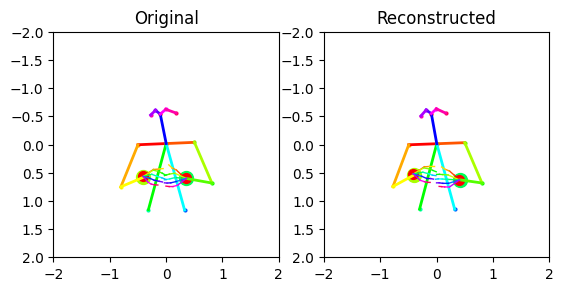

In [256]:
# Plotting video for comparison
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

#for i in range(5):
sample_id = 14 #i
fig, (ax1, ax2) = plt.subplots(1, 2)  # Create subplots with 1 row and 2 columns

def unnormalize_all_frames(tensor):
    unnorm_frames = []
    for i in range(tensor.size(1)):
        column = tensor.detach()[:, i]
        unnorm_frame = utils.unnormalize_mean_std(column)
        unnorm_frames.append(unnorm_frame)
    # Stack the normalized columns back into a tensor
    unnormalized_tensor = torch.stack(unnorm_frames, dim=1)
    return unnormalized_tensor

def draw_sample_video(n):
    ax1.clear()
    ax2.clear()
    print('frame ', n)
    artists = []
    
    tensor = x_test.transpose(1,2)[sample_id].cpu()
    tensor = unnormalize_all_frames(tensor)
    
    # Plot the first data
    utils.draw_from_tensor(tensor[:, n], ax1)
    ax1.set_xlim(-2, 2)
    ax1.set_ylim(2, -2)
    ax1.set_aspect('equal')
    ax1.set_title('Original')

    tensor2 = x_hat_test.transpose(1,2)[sample_id].cpu()
    tensor2 = unnormalize_all_frames(tensor2)
    
    # Plot the second data
    utils.draw_from_tensor(tensor2[:, n], ax2)
    ax2.set_xlim(-2, 2)
    ax2.set_ylim(2, -2)
    ax2.set_aspect('equal')
    ax2.set_title('Reconstructed')
    
    #plt.show()
    return artists

ani = FuncAnimation(fig, draw_sample_video, frames=29, interval=30, blit=True)

from IPython.display import HTML
HTML(ani.to_html5_video())